# Introduction to PyTorch

This is not graded!

© Tim Metzler, Hochschule Bonn-Rhein-Sieg

In [1]:
import torch
import torch.nn as nn

## 1. Dataset

### 1.1 Define dataset

We first need a dataset. This can either be an instance of the class `torch.utils.data.DataSet` or a simple list of tuples like so:

```
dataset = [
    (input1, label1),
    (input2, label2),
    ...
]
```

In [2]:
# XOR dataset
dataset = [
    ([0, 1], [1]),
    ([1, 0], [1]),
    ([1, 1], [0]),
    ([0, 0], [0])
]

### 1.2 Convert dataset to proper type

PyTorch works with tensors, so we need to make sure our labels and inputs are given as tensors

In [3]:
torch_dataset = []

for sample, label in dataset:
    torch_dataset.append(
        (torch.Tensor(sample), torch.tensor(label))
    )
    
for row in torch_dataset:
    print(row)

(tensor([0., 1.]), tensor([1]))
(tensor([1., 0.]), tensor([1]))
(tensor([1., 1.]), tensor([0]))
(tensor([0., 0.]), tensor([0]))


### 1.3 Using the Dataset class

In some cases we might want only create our data when a single example is accessed.

An example could be going from an index to a onehot encoded vector.

In [16]:
from torch.utils.data import Dataset
from typing import List, Tuple

class XORDataset(Dataset):
    
    def __init__(self):
        self.data = [
            ([0, 1], [1]),
            ([1, 0], [1]),
            ([1, 1], [0]),
            ([0, 0], [0])
        ]
        
    def __len__(self) -> int:
        return len(self.data)
    
    def __getitem__(self, index: int) -> Tuple[List[torch.tensor], torch.tensor]:
        return (
            torch.Tensor(self.data[index][0]),
            torch.Tensor(self.data[index][1])
        )
    
# Create the dataset

xor_dataset = XORDataset()

print(len(xor_dataset))
print(xor_dataset[3])

4
(tensor([0., 0.]), tensor([0.]))


## 2. DataLoader

We often like to train our models in batches and shuffle after each epoch.

For this we can use the `torch.utils.data.DataLoader` class.

In [5]:
from torch.utils.data import DataLoader

# This loader will produce the data in batches of 2 and after all batches are done
# it will shuffle the data
data_loader = DataLoader(xor_dataset, batch_size=2, shuffle=True)

# Example of how to iterate over the data this way
for batch_id, data in enumerate(data_loader):
    print(batch_id)
    print(data)
    print("-" * 20)
    
print()
print("Next epoch")
print()

# Lets do it again to see if it shuffled
for batch_id, data in enumerate(data_loader):
    print(batch_id)
    print(data)
    print("-" * 20)

0
[tensor([[1., 0.],
        [0., 1.]]), tensor([[1.],
        [1.]])]
--------------------
1
[tensor([[1., 1.],
        [0., 0.]]), tensor([[0.],
        [0.]])]
--------------------

Next epoch

0
[tensor([[0., 1.],
        [1., 0.]]), tensor([[1.],
        [1.]])]
--------------------
1
[tensor([[1., 1.],
        [0., 0.]]), tensor([[0.],
        [0.]])]
--------------------


## 3. The model

### 3.1 Defining the architecture of your model

For this we need to implement a class that inherits from `torch.nn.Module`.

This class needs a constructor and a forward method.

The forward method tells the model how to get from an input to an output.

In the example below we will create a neural network with 2 hidden layers and a sigmoid activation function.

In [17]:
class XORClassifier(nn.Module):
    
    def __init__(self):
        # We always need to call the constructor of the super class
        super().__init__()
        # Here we define the layers and activations
        # Our activation function will be a sigmoid
        self.activation = nn.Sigmoid()
        # First layer takes our input of dimensionality 2
        # and feeds it into a linear layer with an output of 5
        self.hidden1 = nn.Linear(2, 5)
        
        # Second layer takes our outputs the previous layer of dimensionality 5
        # and feeds it into a linear layer with an output of 1 (same as from our labels)
        # This will be the last layer
        self.hidden2 = nn.Linear(5, 1)
        
    def forward(self, x: torch.TensorType) -> torch.TensorType:
        # Here we need to turn an input into an output
        
        # First we feed it to the first layer
        y = self.hidden1(x)
        # Now we apply the activation to it
        y = self.activation(y)
        # Feed it to the last layer
        y = self.hidden2(y)
        # Apply activation again
        y = self.activation(y)
        return y

### 3.2 Testing the model

Let us perform a forward pass of our model to make sure we implemented it correctly

In [7]:
model = XORClassifier()

# Let us take the first sample from the dataset
sample, label = xor_dataset[0]

# Notice how we don't need to call the forward method explicitly
output = model(sample)

print(output)

# There seems to be a gradient in our output. Why is that?
# How do we get rid of it?
print(output.detach())

output.detach().numpy()

tensor([0.5533], grad_fn=<SigmoidBackward0>)
tensor([0.5533])


array([0.5532673], dtype=float32)

### 3.3 Testing the model with more inputs

What happens if instead of one example we feed more examples like our data loader produces?

In [8]:
for batch_id, data in enumerate(data_loader):
    print("#" * 30)
    print(f"Batch number {batch_id}")
    samples, labels = data
    print("Our inputs are", samples)
    print("Our labels are", labels)
    # Lets try to feed all of the samples at the same time
    outputs = model(samples)
    print("Our outputs are", outputs)
    # Notice how we can feed more inputs at once?


##############################
Batch number 0
Our inputs are tensor([[1., 0.],
        [0., 1.]])
Our labels are tensor([[1.],
        [1.]])
Our outputs are tensor([[0.5397],
        [0.5533]], grad_fn=<SigmoidBackward0>)
##############################
Batch number 1
Our inputs are tensor([[0., 0.],
        [1., 1.]])
Our labels are tensor([[0.],
        [0.]])
Our outputs are tensor([[0.5326],
        [0.5602]], grad_fn=<SigmoidBackward0>)


## 4. Training the model

### 4.1 The loss

The loss tells us how wrong our classifier is on an input. It is a function of the predicted output and the desired output.

Common loss functions are mean squared error loss (MSELoss) or cross entropy loss.

Let us look at it for one example

In [9]:
from torch.nn import CrossEntropyLoss, MSELoss

mse_loss = MSELoss()
ce_loss = CrossEntropyLoss()

for batch_id, data in enumerate(data_loader):
    print("#" * 30)
    print(f"Batch number {batch_id}")
    samples, labels = data
    print("Our inputs are", samples)
    print("Our labels are", labels)
    # Lets try to feed all of the samples at the same time
    outputs = model(samples)
    print("Our outputs are", outputs)
    
    loss_1 = mse_loss(outputs, labels)
    # Compute the loss
    print(loss_1)
    
    print(ce_loss(outputs, labels))
    
    
    
    # Lets stop here
    break

##############################
Batch number 0
Our inputs are tensor([[1., 1.],
        [0., 1.]])
Our labels are tensor([[0.],
        [1.]])
Our outputs are tensor([[0.5602],
        [0.5533]], grad_fn=<SigmoidBackward0>)
tensor(0.2567, grad_fn=<MseLossBackward0>)
tensor(-0., grad_fn=<DivBackward1>)


### 4.2 The optimizer

We now have our inputs, outputs and a loss that tells us how wrong we are.

Now we need to take that information to actually update (optimize) the weights of our network.

If in doubt always use Adam

In [10]:
from torch.optim import AdamW

# Create our optimizer (Adam) with a learning rate of 0.1
optimizer = AdamW(model.parameters(), lr=0.1)
# Notice how the optimizer knows about our model by giving the parameters?

### 4.3 The training loop

Now we can create our training loop for one epoch

In [11]:
model = XORClassifier()

batch_losses = []

for batch_id, data in enumerate(data_loader):
    samples, labels = data
    outputs = model(samples)
    
    # We need to zero our gradients for every batch!
    optimizer.zero_grad()
    
    # Calculate loss
    loss = mse_loss(outputs, labels)
    
    # Calculate gradient from loss
    loss.backward()
    
    # Update weights
    optimizer.step()
    
    # Record the loss
    batch_losses.append(loss.item())
    
batch_losses 

[0.2626611292362213, 0.2513211965560913]

### 4.4 The full loop with epochs

In [12]:
model = XORClassifier()

optimizer = AdamW(model.parameters(), lr=0.1)

mse_loss = MSELoss()

def train_for_n_epochs(epochs, data_loader, loss_fn, model, optimizer):
    epoch_losses = []

    for epoch in range(epochs):
        batch_losses = []

        for batch_id, data in enumerate(data_loader):
            samples, labels = data
            outputs = model(samples)

            # We need to zero our gradients for every batch!
            optimizer.zero_grad()

            # Calculate loss
            loss = loss_fn(outputs, labels)

            # Calculate gradient from loss
            loss.backward()

            # Update weights
            optimizer.step()

            # Record the loss
            batch_losses.append(loss.item())

        epoch_losses.append(sum(batch_losses) / len(batch_losses))
        
    return epoch_losses

losses = train_for_n_epochs(1000, data_loader, mse_loss, model, optimizer)

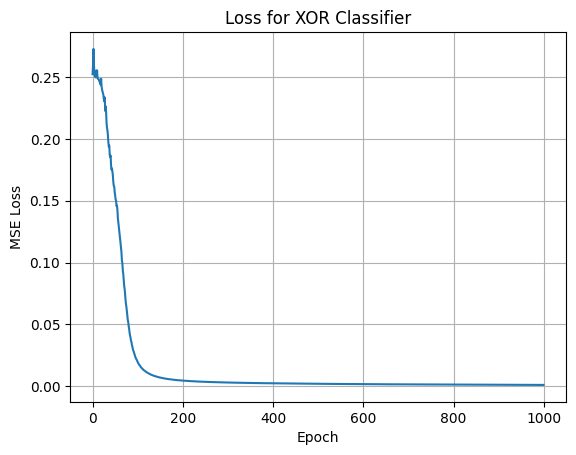

In [13]:
import matplotlib.pyplot as plt

plt.plot(losses)

plt.grid()
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Loss for XOR Classifier")

plt.show()

In [14]:
for data in xor_dataset:
    samples, labels = data
    output = model(samples)
    print(samples, output, labels)

tensor([0., 1.]) tensor([0.9719], grad_fn=<SigmoidBackward0>) tensor([1.])
tensor([1., 0.]) tensor([0.9771], grad_fn=<SigmoidBackward0>) tensor([1.])
tensor([1., 1.]) tensor([0.0462], grad_fn=<SigmoidBackward0>) tensor([0.])
tensor([0., 0.]) tensor([0.0242], grad_fn=<SigmoidBackward0>) tensor([0.])


## 5. Some experiments

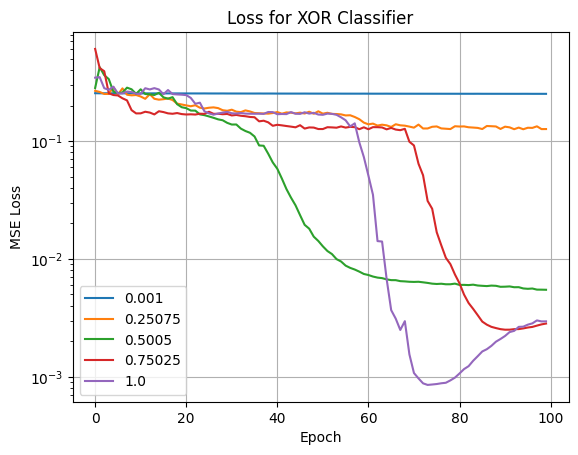

In [15]:
import numpy as np

loss_dict = dict()

for learning_rate in np.linspace(0.001, 1, 5):
    model = XORClassifier()
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    loss_fn = MSELoss()
    
    losses = train_for_n_epochs(100, model=model, data_loader=data_loader, optimizer=optimizer, loss_fn=loss_fn)
    
    loss_dict[learning_rate] = losses
    
    
for key, value in loss_dict.items():
    plt.plot(value, label=key)
    
    
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Loss for XOR Classifier")
plt.legend()
plt.yscale("log")
plt.show()